## imports

In [2]:
import pandas as pd
import numpy as np
import mne

In [5]:
dataset_dir = 'ds001787/'

In [34]:
raw = mne.io.read_raw_bdf(
    r'ds001787\sub-001\ses-01\eeg\sub-001_ses-01_task-meditation_eeg.bdf',
    preload=True
)

Extracting EDF parameters from C:\projects\eegnets\ds001787\sub-001\ses-01\eeg\sub-001_ses-01_task-meditation_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 696575  =      0.000 ...  2720.996 secs...


In [17]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 79 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 52.0 Hz
 meas_date: 2014-04-04 19:40:17 UTC
 nchan: 80
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>

Using matplotlib as 2D backend.


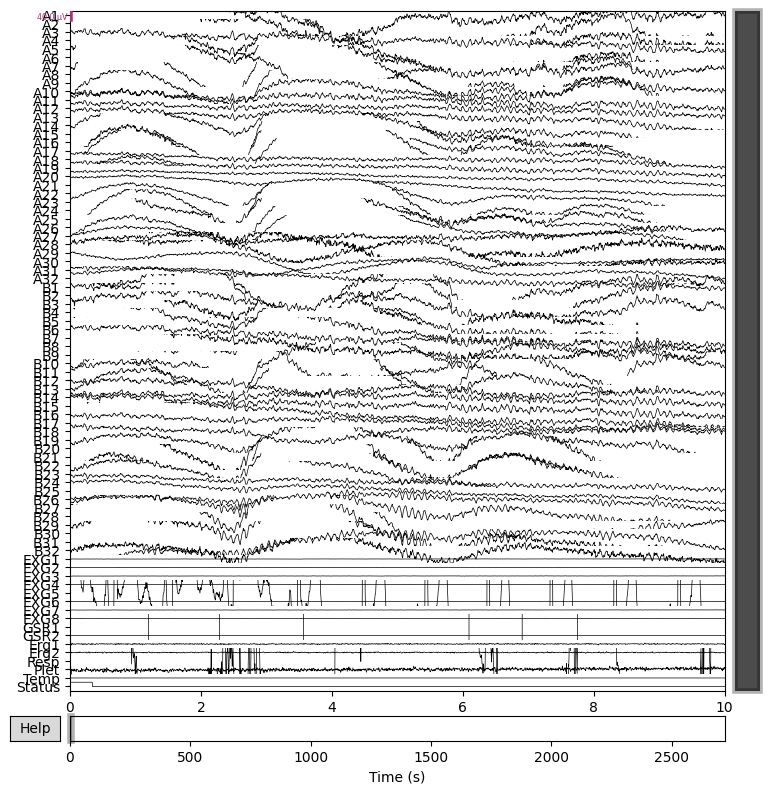

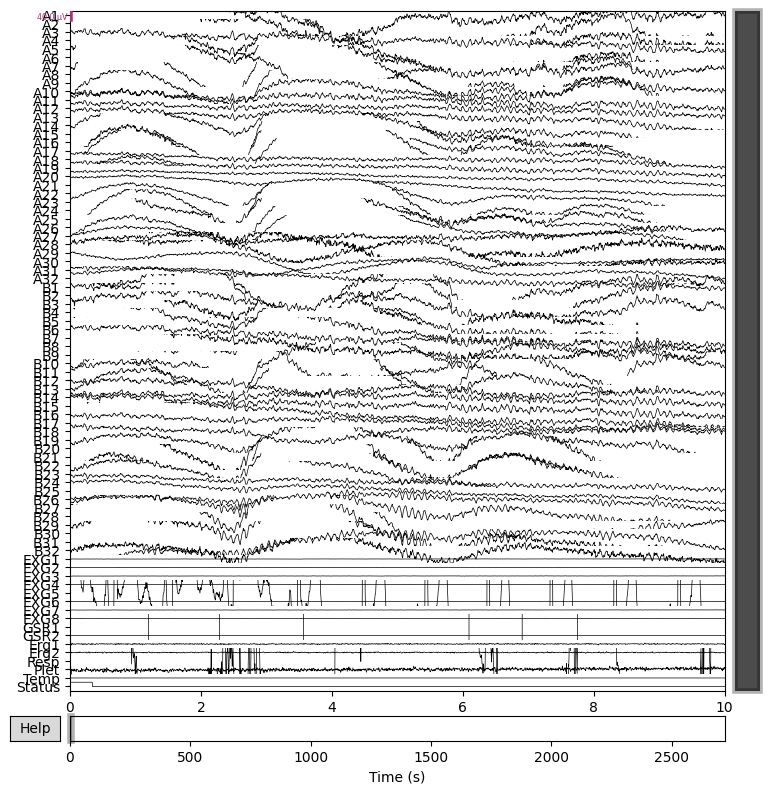

In [18]:
raw.plot(duration = 10, n_channels =80)

In [37]:
df_ch = pd.read_csv('ds001787/task-meditation_channels.tsv', sep="\t")

#Extract EEG names
eeg_names = df_ch[df_ch["type"] == "EEG"]["name"].tolist()
assert len(eeg_names) == 64

#Rename A1–B32 → EEG names
rename_map = dict(zip(raw.ch_names[:64], eeg_names))
raw.rename_channels(rename_map)

#DROP non-EEG channels (THIS WAS MISSING)
raw.pick_channels(eeg_names)

#Set montage
raw.set_montage("standard_1020", match_case=False)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | sub-001_ses-01_task-meditation_eeg.bdf, 64 x 696576 (2721.0 s), ~340.2 MB, data loaded>

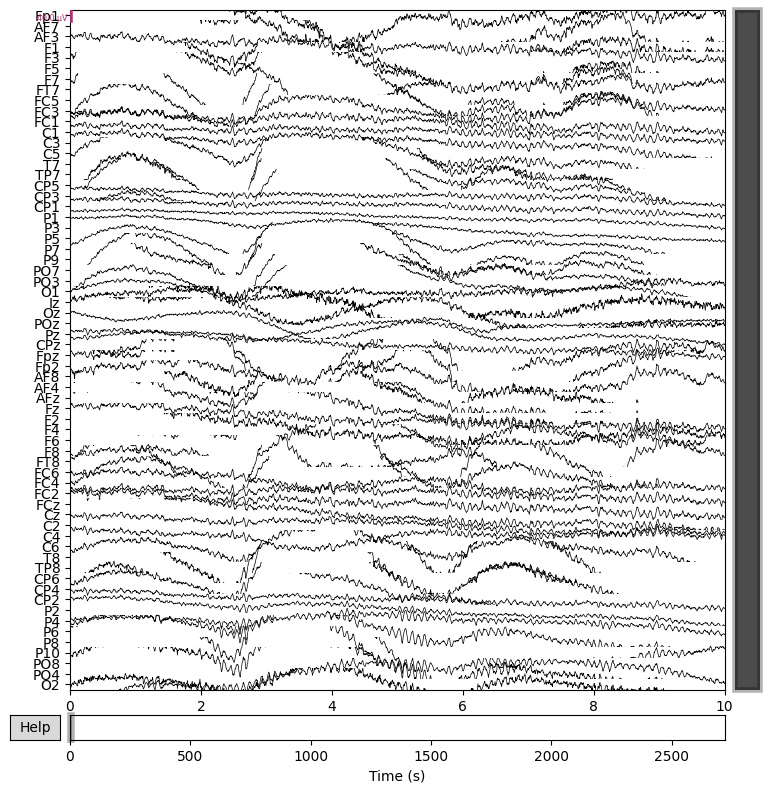

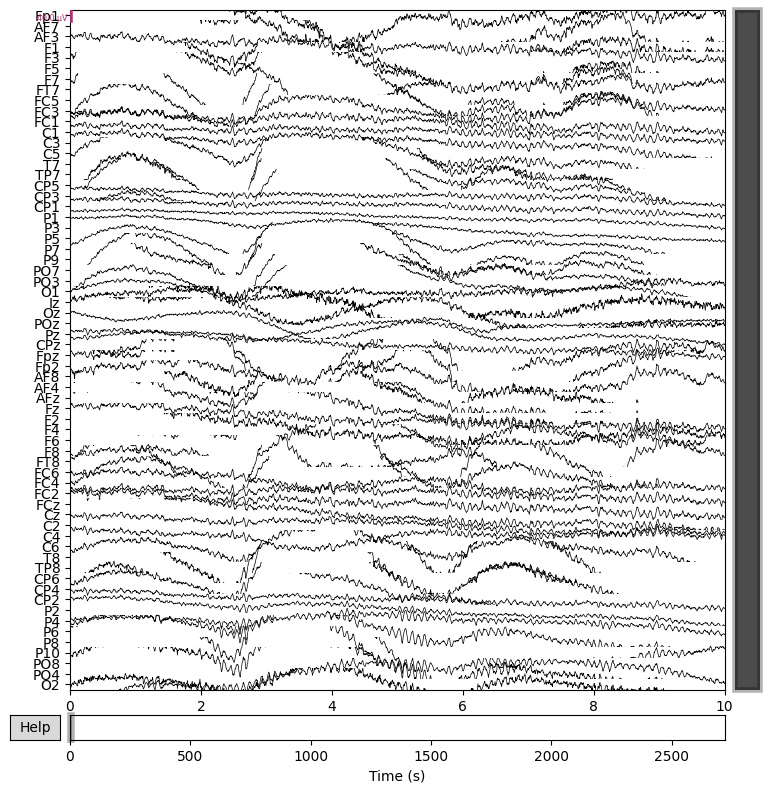

In [38]:
raw.plot(n_channels = 80, duration = 10)

In [39]:
print(len(raw.ch_names))

64


In [40]:
print(raw.times[0], raw.times[-1])
raw.crop(tmin=5.0, tmax=raw.times[-1] - 5.0)
print("*"*64)
print(raw.times[0], raw.times[-1])

0.0 2720.99609375
****************************************************************
0.0 2710.99609375


In [41]:
df = pd.read_csv('ds001787/sub-001/ses-01/eeg/sub-001_ses-01_task-meditation_events.tsv', sep="\t")

# get stimulus onsets (value == 128)
probe_times = df.loc[
    (df["trial_type"] == "stimulus") & (df["value"] == 128),
    "onset"
].values

print(probe_times)

[  71.38671875  125.609375    179.80078125  284.859375    362.17578125
  422.69921875  511.1953125   610.55078125  688.87890625  747.796875
  912.6484375   970.21484375  999.11328125 1118.3671875  1252.671875
 1330.38671875 1497.2109375  1587.796875   1735.734375   1882.98046875
 2037.25       2091.46484375 2240.66015625 2297.625      2387.9609375
 2477.16015625 2589.13671875 2645.671875  ]


In [42]:
TRIM = 5.0  # seconds

meditation_windows = []

for i in range(len(probe_times) - 1):
    start = probe_times[i] + TRIM
    end   = probe_times[i + 1] - TRIM

    # keep only meaningful windows
    if end > start:
        meditation_windows.append((start, end))


clean_segments = []

for start, end in meditation_windows:
    seg = raw.copy().crop(tmin=start, tmax=end)
    if seg.times[-1] > 1.0:  # at least 1 second
        clean_segments.append(seg)

raw_clean = mne.concatenate_raws(clean_segments)


<RawEDF | sub-001_ses-01_task-meditation_eeg.bdf, 64 x 589924 (2304.4 s), ~288.1 MB, data loaded>


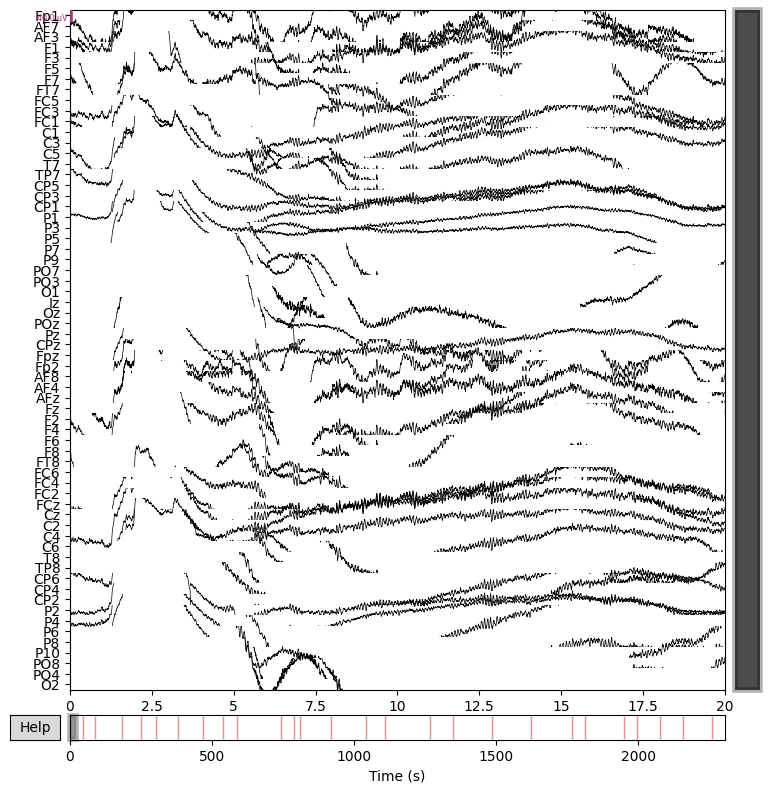

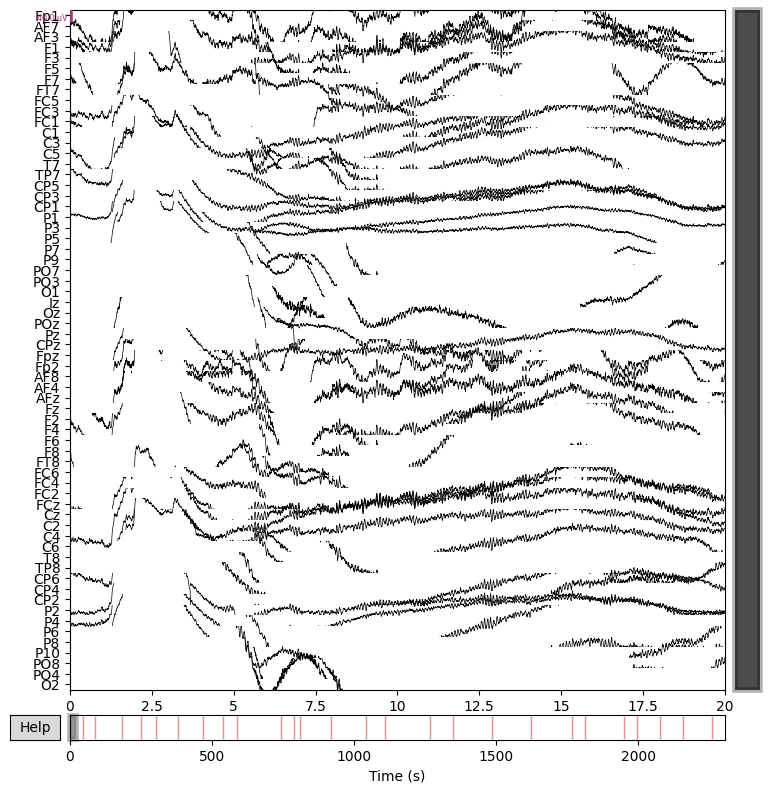

In [46]:
print(raw_clean)
raw_clean.plot(n_channels=64, duration = 20)

In [47]:
TARGET_SFREQ = 256

if int(raw_clean.info["sfreq"]) != TARGET_SFREQ:
    raw_clean.resample(TARGET_SFREQ, npad="auto")


In [55]:
raw_clean.filter(
    l_freq=1.0, h_freq=40.0, fir_design="firwin", verbose=False
)
raw.info

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 52.0 Hz
 meas_date: 2014-04-04 19:40:17 UTC
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>

In [56]:
raw_clean.notch_filter(freqs=[50], fir_design="firwin", verbose=False)

<RawEDF | sub-001_ses-01_task-meditation_eeg.bdf, 64 x 589924 (2304.4 s), ~288.1 MB, data loaded>

In [57]:
raw_clean.set_eeg_reference("average", verbose=False)

<RawEDF | sub-001_ses-01_task-meditation_eeg.bdf, 64 x 589924 (2304.4 s), ~288.1 MB, data loaded>

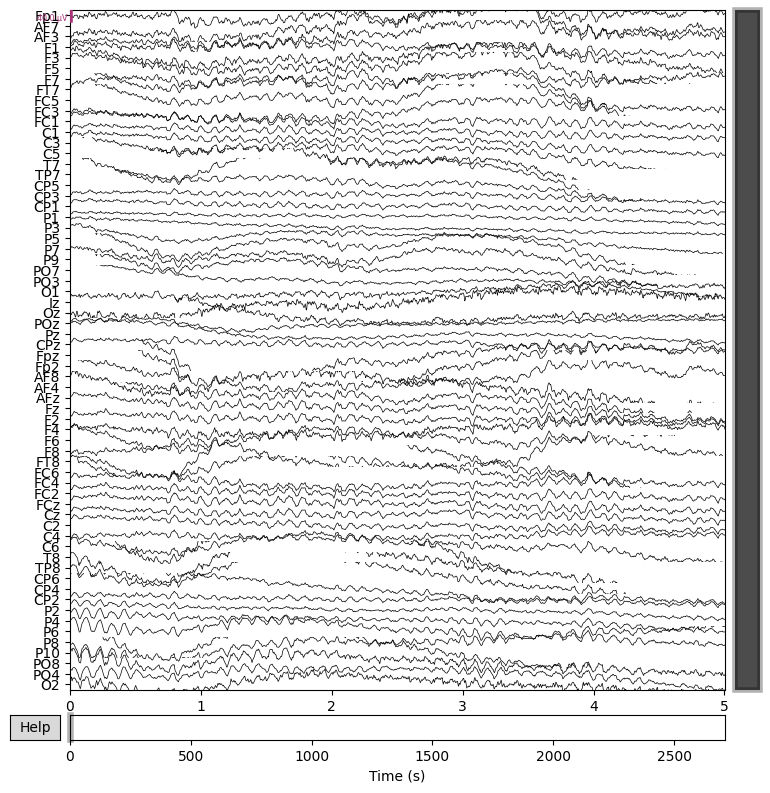

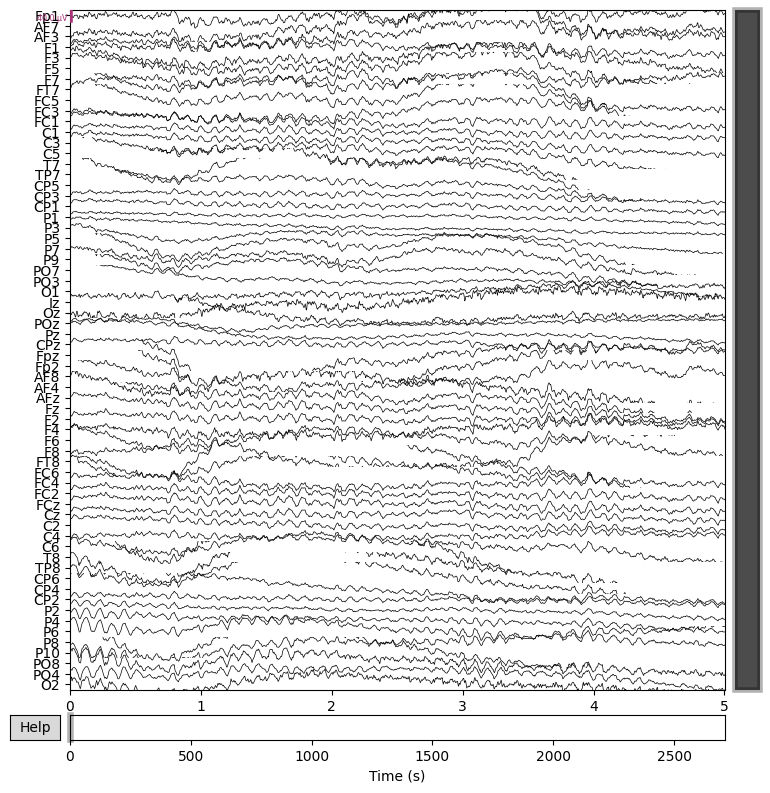

In [60]:
raw.plot(n_channels=80, duration = 5)

Number of windows: 459
Window shape: (64, 2560)
(459, 64, 2560)


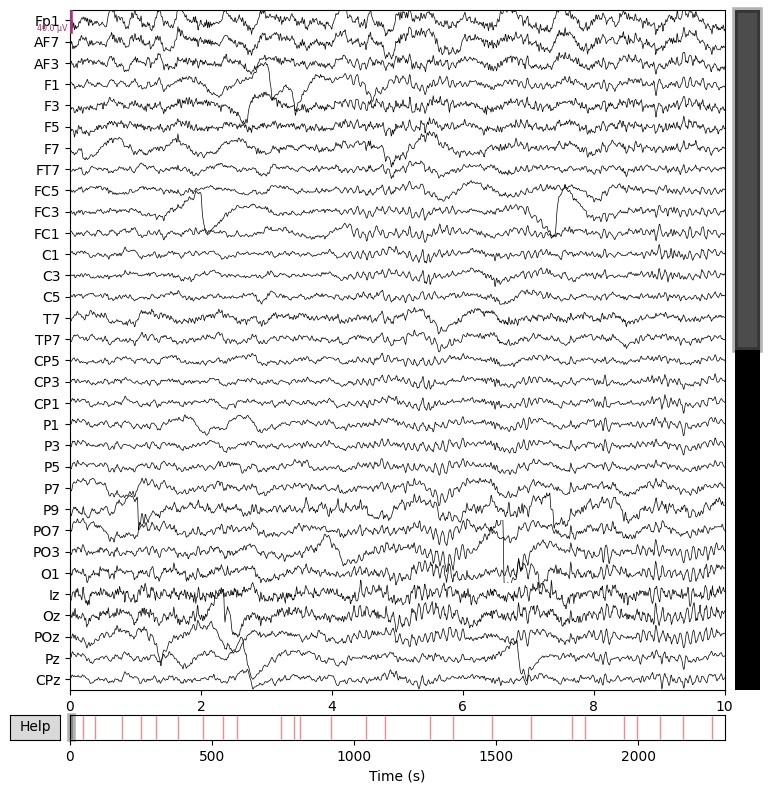

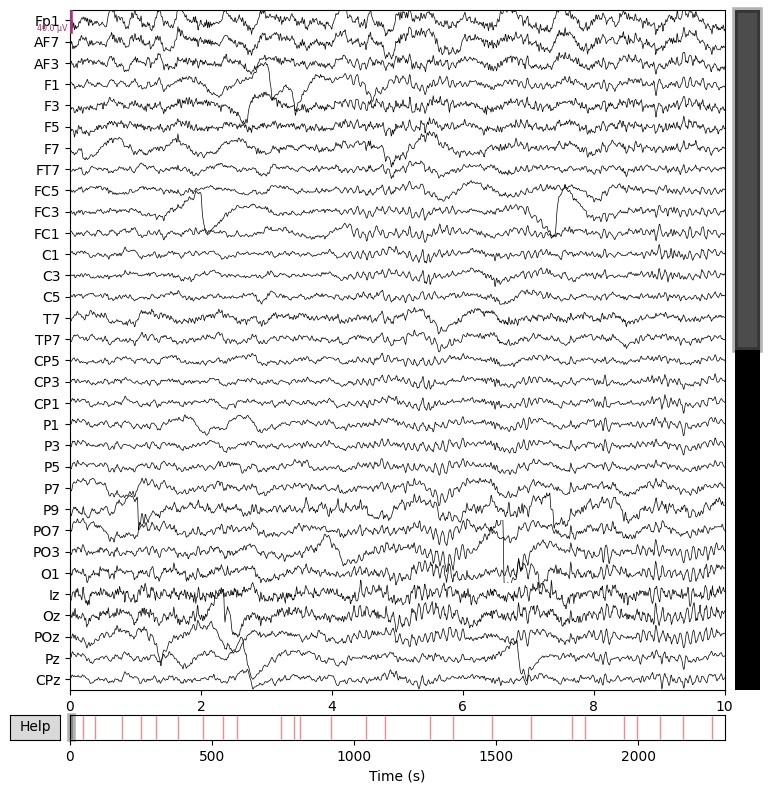

In [61]:
WINDOW_SEC = 10.0
OVERLAP = 0.5   # 50%
STEP_SEC = WINDOW_SEC * (1 - OVERLAP)

sfreq = raw_clean.info["sfreq"]
win_samples  = int(WINDOW_SEC * sfreq)
step_samples = int(STEP_SEC * sfreq)

X_windows = []

data = raw_clean.get_data()  # shape: (C, T)
n_chans, n_times = data.shape

start = 0
while start + win_samples <= n_times:
    window = data[:, start:start + win_samples]  # (C, T_window)
    X_windows.append(window)
    start += step_samples

X_windows = np.stack(X_windows)  # (N, C, T)


print("Number of windows:", X_windows.shape[0])
print("Window shape:", X_windows.shape[1:])
print(X_windows.shape)

raw_clean.plot(duration=10, n_channels=32)

In [1]:
import pandas as pd
df = pd.read_csv(
    'features_region_all_subjects.csv'
)

In [3]:
df.columns

Index(['Frontal_logbp_delta', 'Frontal_relbp_delta', 'Frontal_logbp_theta',
       'Frontal_relbp_theta', 'Frontal_logbp_alpha', 'Frontal_relbp_alpha',
       'Frontal_logbp_beta', 'Frontal_relbp_beta', 'Frontal_theta_beta',
       'Frontal_alpha_theta', 'Central_logbp_delta', 'Central_relbp_delta',
       'Central_logbp_theta', 'Central_relbp_theta', 'Central_logbp_alpha',
       'Central_relbp_alpha', 'Central_logbp_beta', 'Central_relbp_beta',
       'Central_theta_beta', 'Central_alpha_theta', 'Parietal_logbp_delta',
       'Parietal_relbp_delta', 'Parietal_logbp_theta', 'Parietal_relbp_theta',
       'Parietal_logbp_alpha', 'Parietal_relbp_alpha', 'Parietal_logbp_beta',
       'Parietal_relbp_beta', 'Parietal_theta_beta', 'Parietal_alpha_theta',
       'Occipital_logbp_delta', 'Occipital_relbp_delta',
       'Occipital_logbp_theta', 'Occipital_relbp_theta',
       'Occipital_logbp_alpha', 'Occipital_relbp_alpha',
       'Occipital_logbp_beta', 'Occipital_relbp_beta', 'Occipital_th